<a href="https://colab.research.google.com/github/Konstantinosil/Chortareas-Linardatos-A-Macro-Augmented-Jump-Diffusion-Shadow-Rate-Model/blob/main/Determinants_of_Central_Bank_Credibility_After_the_GFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running pipeline (RF → AP(3), Hamilton gap, two-way cluster, wild bootstrap)

Frequency audit of /content/chapter 2.xlsx
Policy Rates EU                     n=5145 freq≈D
Inflation EU                        n= 169 freq≈MS
Volatility EU                       n=3584 freq≈None
RGDP EU                             n=  53 freq≈QS-OCT
Composite Leader Indicator EU       n= 169 freq≈MS
Policy Rates UK                     n=3675 freq≈B
Inflation UK                        n= 169 freq≈MS
Volatility UK                       n=3558 freq≈None
RGDP UK                             n=  57 freq≈QS-OCT
Composite Leader Indicator UK       n= 169 freq≈MS
Policy Rates US                     n= 169 freq≈MS
Inflation US                        n= 169 freq≈MS
Volatility US                       n=3546 freq≈None
RGDP US                             n=  53 freq≈QS-OCT
Composite Leader Indicator US       n= 169 freq≈MS

[Pre-RF sanity]
{'n_i': {'BoE': 169, 'ECB': 169, 'Fed': 169}, 'n_pi': {'BoE': 157, 'ECB': 157, 'F

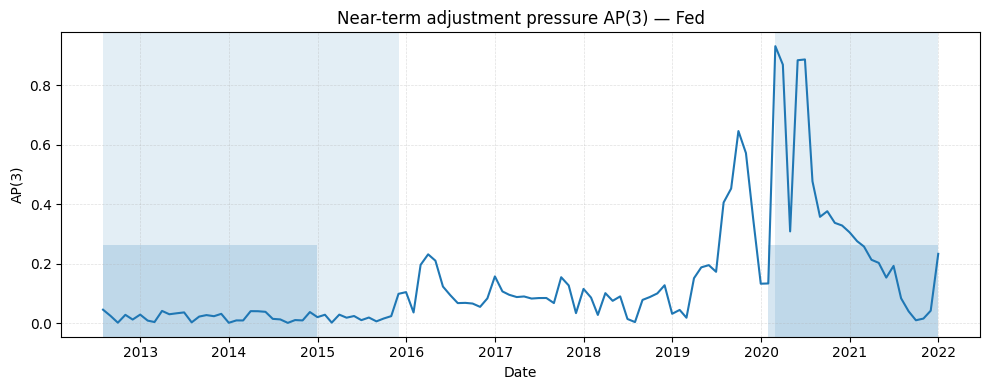

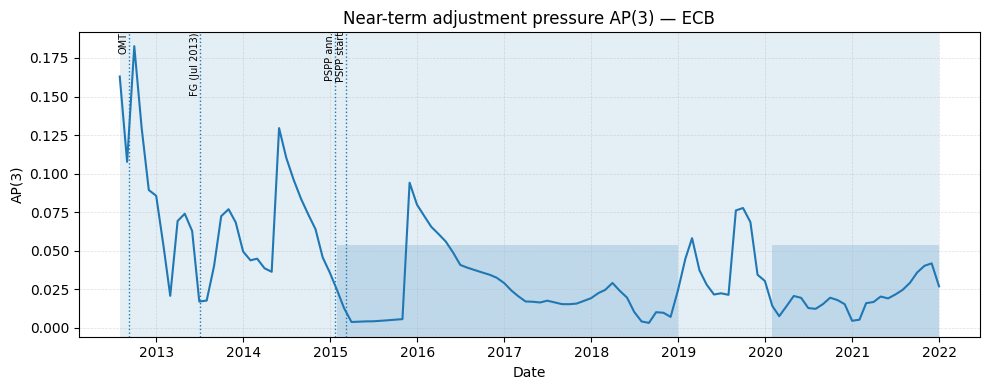

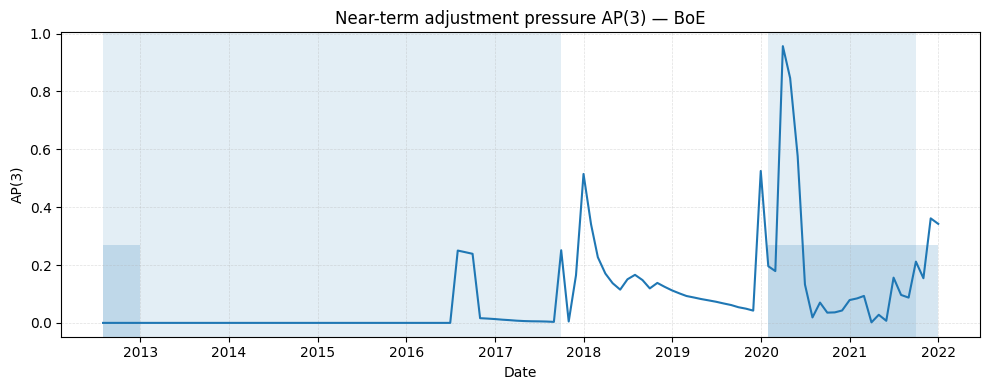


AP(3) descriptives by bank × ELB regime
bank  ELB     mean       sd      p25      p50      p75
 BoE    0 0.160210 0.130236 0.078858 0.121964 0.165717
 BoE    1 0.059745 0.159577 0.000000 0.000000 0.029868
 ECB    1 0.038294 0.033822 0.016353 0.024499 0.051910
 Fed    0 0.137880 0.132369 0.069638 0.094540 0.153438
 Fed    1 0.135677 0.229305 0.013618 0.028995 0.194934


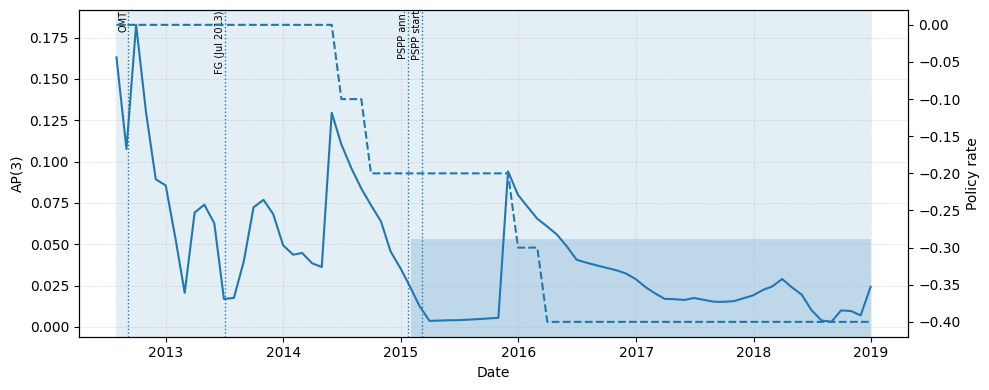


ECB AP(3) case-study windows (OMT / PSPP / FG)
                 window      start        end  mean_AP3   sd_AP3      p25      p50      p75  n
             OMT window 2011-10-01 2013-04-30  0.097430 0.049603 0.070403 0.087450 0.124074 10
Pre-PSPP / disinflation 2014-01-01 2015-02-28  0.059841 0.034325 0.036832 0.045214 0.081180 14
             Early PSPP 2015-03-01 2016-12-31  0.034593 0.028168 0.004889 0.035088 0.054066 22
      Late PSPP / taper 2017-01-01 2018-12-31  0.016623 0.006661 0.013980 0.016910 0.020940 24

DIAGNOSTICS (availability / NaNs)
[avail] abs_deltai_3m: {'BoE': 166, 'ECB': 166, 'Fed': 166}
[avail] abs_surprise_rel_3_rt: {'BoE': 114, 'ECB': 114, 'Fed': 114}
[NaN] ELB: {'BoE': 0, 'ECB': 0, 'Fed': 0}

[panel_sanity] coverage:
  BoE: 2008-01-31 → 2022-03-31  n=171  monotonic=True
  ECB: 2008-01-31 → 2022-01-31  n=169  monotonic=True
  Fed: 2008-01-31 → 2022-01-31  n=169  monotonic=True

--------------------------------------------------------------------------
H1A — Ou

In [2]:
"""
Determinants of Central Bank Credibility After the GFC
====================================================

Journal-ready replication pipeline (monthly panel; ECB/BoE/Fed; 2008–2022).

Key objects:
- Rolling real-time reaction function for Δi and surprises (di_surpr_rt)
- AP(3) = |sum_{t+1..t+3} di_surpr_rt| (near-term adjustment pressure)
- FE panel regressions (bank×year FE + month FE), HAC + two-way clustering + wild cluster bootstrap
- H1A/H1B/H2/H3 specifications + robustness (LOBO / by-bank / horizon profiles)
- Orthogonalization / cross-fitting checks for generated regressors (A/B splits; residualization)

CHANGE REQUEST (implemented):
- Removed ONLY the following H3 add-ons for the inflation gap variables:
  (i) LOBO for abs_infl_gap
  (ii) By-bank slopes for abs_infl_gap and abs_infl_gap×ELB
  (iii) Horizon profiles for abs_infl_gap and abs_infl_gap×ELB
- All other diagnostics/robustness outputs remain unchanged.

Usage:
- Put "chapter 2.xlsx" either in /content (Colab) or in /mnt/data (local sandbox).
- Run this file as a script.

Outputs:
- Prints main results to stdout.
- If SAVE_FILES=True, saves figures (.pdf) and tables (.tex/.csv) to OUTDIR.

"""

from __future__ import annotations

import os
import random
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Sequence, Tuple, Union

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

warnings.filterwarnings("ignore")


# =============================================================================
# Configuration
# =============================================================================

@dataclass(frozen=True)
class Config:
    # Paths
    ROOT_COLAB: str = "/content"
    ROOT_LOCAL: str = "/mnt/data"
    XLS_NAME: str = "chapter 2.xlsx"
    OUTDIR_DEFAULT: str = "/mnt/data"

    # Sample
    START: str = "2008-01-01"
    END: str = "2022-12-31"

    # Targets / constants
    PI_STAR: float = 2.0
    R_STAR: float = 1.0

    # Defaults
    RHO_DEFAULT: float = 0.8
    HAC_LAGS_BASE: int = 6
    ELB_EPS: float = 0.10

    # ELB fixed thresholds (optional mode)
    ELB_THRESHOLDS: Dict[str, float] = None

    # RF window candidates
    RF_WINDOW_CAND: Tuple[int, ...] = (36, 48, 60, 72, 84)

    # Saving
    SAVE_FILES: bool = False

    # Seeds
    SEED: int = 123

    def __post_init__(self):
        if self.ELB_THRESHOLDS is None:
            object.__setattr__(self, "ELB_THRESHOLDS", {"ECB": 0.10, "BoE": 0.25, "Fed": 0.25})


CFG = Config()


def set_seeds(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)


# =============================================================================
# Path helpers
# =============================================================================

def resolve_root(cfg: Config) -> Path:
    """Resolve ROOT depending on whether the Excel file exists under Colab path."""
    root_colab = Path(cfg.ROOT_COLAB)
    root_local = Path(cfg.ROOT_LOCAL)
    if (root_colab / cfg.XLS_NAME).exists():
        return root_colab
    return root_local


def ensure_outdir(cfg: Config, root: Path) -> Path:
    outdir = Path(cfg.OUTDIR_DEFAULT) if Path(cfg.OUTDIR_DEFAULT).is_dir() else root
    outdir.mkdir(parents=True, exist_ok=True)
    return outdir


# =============================================================================
# Utilities
# =============================================================================

def freq_audit(xls_path: Union[str, Path]) -> None:
    xls_path = str(xls_path)
    try:
        xls = pd.ExcelFile(xls_path)
    except Exception as e:
        print(f"[freq_audit] Cannot open {xls_path}: {e}")
        return

    print("\n" + "=" * 120)
    print(f"Frequency audit of {xls_path}")
    print("=" * 120)

    for sh in xls.sheet_names:
        d = pd.read_excel(xls_path, sheet_name=sh)
        if "Date" not in d.columns:
            print(f"{sh:35s} n={len(d):4d} freq≈None")
            continue
        dd = d.copy()
        dd["Date"] = pd.to_datetime(dd["Date"], errors="coerce")
        dd = dd.dropna(subset=["Date"]).sort_values("Date")
        try:
            freq = pd.infer_freq(dd["Date"])
        except Exception:
            freq = None
        print(f"{sh:35s} n={len(dd):4d} freq≈{str(freq) or 'None'}")


def smooth_series(s: pd.Series, rho: float) -> pd.Series:
    """Simple exponential smoothing recursion."""
    s = pd.to_numeric(s, errors="coerce")
    out: List[float] = []
    prev = np.nan
    for x in s.values:
        if np.isnan(prev) or np.isnan(x) or rho == 0.0:
            out.append(x)
            prev = x
        else:
            val = (1 - rho) * x + rho * prev
            out.append(val)
            prev = val
    return pd.Series(out, index=s.index)


def winsorize(df: pd.DataFrame, cols: Sequence[str], p: float = 0.01) -> pd.DataFrame:
    z = df.copy()
    for c in cols:
        if c in z.columns:
            lo, hi = z[c].quantile([p, 1 - p])
            z[c] = z[c].clip(lo, hi)
    return z


def merge_no_overlap(
    left: pd.DataFrame,
    right: pd.DataFrame,
    on: Sequence[str],
    suffix: str = "_r",
    how: str = "left",
    validate: Optional[str] = None
) -> pd.DataFrame:
    on = list(on)
    overlap = (set(left.columns) & set(right.columns)) - set(on)
    r = right.rename(columns={c: f"{c}{suffix}" for c in overlap})
    return left.merge(r, on=on, how=how, validate=validate)


def params_as_series(res) -> pd.Series:
    return pd.Series(res.params, index=res.model.exog_names).astype(float)


def bse_as_series(res) -> pd.Series:
    return pd.Series(res.bse, index=res.model.exog_names).astype(float)


def pvalues_as_series(res) -> pd.Series:
    return pd.Series(res.pvalues, index=res.model.exog_names).astype(float)


def safe_get_triplet(res, name: str) -> Tuple[float, float, float]:
    b = params_as_series(res)
    se = bse_as_series(res)
    pv = pvalues_as_series(res)
    return float(b.get(name, np.nan)), float(se.get(name, np.nan)), float(pv.get(name, np.nan))


# =============================================================================
# Data IO
# =============================================================================

def read_block(xls_path: Union[str, Path], sheet: str, bank: str, value_col: str) -> pd.DataFrame:
    """Read one sheet, normalize to columns: date, bank, value_col."""
    d = pd.read_excel(str(xls_path), sheet_name=sheet)
    d = d.rename(columns={"Date": "date", value_col: value_col})
    d["date"] = pd.to_datetime(d["date"], errors="coerce")

    x = pd.to_numeric(d[value_col], errors="coerce")

    # Robust parsing if stored as strings with %, commas, unicode minus, etc.
    if x.notna().mean() < 0.5:
        raw = d[value_col].astype(str)
        x = (
            raw.str.replace("%", "", regex=False)
               .str.replace("\u2212", "-", regex=False)
               .str.replace(" ", "", regex=False)
               .str.replace(",", ".", regex=False)
        )
        x = pd.to_numeric(x, errors="coerce")
        d[value_col] = x

    d["bank"] = bank
    return d[["date", "bank", value_col]].sort_values("date")


def read_all(xls_path: Union[str, Path]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    eu_pol = read_block(xls_path, "Policy Rates EU", "ECB", "POLICY")
    eu_inf = read_block(xls_path, "Inflation EU", "ECB", "INF")
    eu_vol = read_block(xls_path, "Volatility EU", "ECB", "VOL")
    eu_gdp = read_block(xls_path, "RGDP EU", "ECB", "GDP")
    eu_cli = read_block(xls_path, "Composite Leader Indicator EU", "ECB", "CLI")

    uk_pol = read_block(xls_path, "Policy Rates UK", "BoE", "POLICY")
    uk_inf = read_block(xls_path, "Inflation UK", "BoE", "INF")
    uk_vol = read_block(xls_path, "Volatility UK", "BoE", "VOL")
    uk_gdp = read_block(xls_path, "RGDP UK", "BoE", "GDP")
    uk_cli = read_block(xls_path, "Composite Leader Indicator UK", "BoE", "CLI")

    us_pol = read_block(xls_path, "Policy Rates US", "Fed", "POLICY")
    us_inf = read_block(xls_path, "Inflation US", "Fed", "INF")
    us_vol = read_block(xls_path, "Volatility US", "Fed", "VOL")
    us_gdp = read_block(xls_path, "RGDP US", "Fed", "GDP")
    us_cli = read_block(xls_path, "Composite Leader Indicator US", "Fed", "CLI")

    pol = pd.concat([eu_pol, uk_pol, us_pol], ignore_index=True)
    inf = pd.concat([eu_inf, uk_inf, us_inf], ignore_index=True)
    vol = pd.concat([eu_vol, uk_vol, us_vol], ignore_index=True)
    gdp = pd.concat([eu_gdp, uk_gdp, us_gdp], ignore_index=True)
    cli = pd.concat([eu_cli, uk_cli, us_cli], ignore_index=True)
    return pol, inf, vol, gdp, cli


# =============================================================================
# Hamilton output gap
# =============================================================================

def hamilton_output_gap(log_gdp: pd.Series, k: int = 12) -> pd.Series:
    """
    Hamilton (2018) output gap proxy: recursive regression on k lags, residual at t.
    """
    y = pd.to_numeric(log_gdp, errors="coerce")
    Xlags = pd.concat([y.shift(i) for i in range(1, k + 1)], axis=1)
    Xlags.columns = [f"lag{i}" for i in range(1, k + 1)]

    resid = pd.Series(index=y.index, dtype=float)
    for t in range(k + 8, len(y)):
        X_t = sm.add_constant(Xlags.iloc[:t].dropna())
        idx = X_t.index
        y_t = y.loc[idx]
        if len(y_t) >= k + 5:
            beta = sm.OLS(y_t, X_t).fit().params
            row = sm.add_constant(Xlags.iloc[t:t + 1]).iloc[0]
            y_hat = float((row * beta.reindex(row.index).fillna(0)).sum())
            resid.iloc[t] = y.iloc[t] - y_hat

    return resid * 100.0


# =============================================================================
# Panel build
# =============================================================================

def to_monthly_panel(
    xls_path: Union[str, Path],
    cfg: Config,
    rho: float,
    elb_mode: str = "data_driven",
    elb_eps: float = None
) -> pd.DataFrame:
    """
    Builds monthly panel with:
      policy_rate, infl_yoy, volatility, cli, gdp, output_gap, inflation_gap,
      ELB, QE_FG, crisis10, pandem, Δi and leads/lags.
    """
    if elb_eps is None:
        elb_eps = cfg.ELB_EPS

    pol, inf, vol, gdp, cli = read_all(xls_path)

    def infer_yoy_from_INF(series: pd.Series) -> pd.Series:
        s = pd.to_numeric(series, errors="coerce")
        med = s.median()
        # If median is high (likely index level), convert to yoy growth rate
        return s.pct_change(12, fill_method=None) * 100.0 if (np.isfinite(med) and med > 30) else s

    res = []
    for b in ["ECB", "BoE", "Fed"]:
        gpol = pol[pol["bank"] == b].set_index("date").sort_index()
        m_pol = gpol["POLICY"].resample("ME").last()

        gvol = vol[vol["bank"] == b].set_index("date").sort_index()
        m_vol = gvol["VOL"].resample("ME").mean()

        ginf = inf[inf["bank"] == b].set_index("date").sort_index()
        m_inf = ginf["INF"].resample("ME").last()
        m_infl_yoy = infer_yoy_from_INF(m_inf)

        gcli = cli[cli["bank"] == b].set_index("date").sort_index()
        m_cli = gcli["CLI"].resample("ME").last()

        ggdp = gdp[gdp["bank"] == b].copy()
        ggdp["GDP"] = pd.to_numeric(ggdp["GDP"], errors="coerce")
        ggdp = ggdp.set_index("date").sort_index()
        q_end = ggdp.copy()
        q_end.index = q_end.index.to_period("Q").to_timestamp("Q")
        m_gdp = q_end["GDP"].resample("M").interpolate("linear").resample("ME").last()

        mm = pd.concat([m_pol, m_vol, m_infl_yoy, m_cli, m_gdp], axis=1)
        mm.columns = ["policy_rate", "volatility", "infl_yoy", "cli", "gdp"]
        mm["bank"] = b
        mm = mm.reset_index().rename(columns={"index": "date"})
        res.append(mm)

    mon = pd.concat(res, ignore_index=True)

    START = pd.to_datetime(cfg.START)
    END = pd.to_datetime(cfg.END)
    mon = mon[(mon["date"] >= START) & (mon["date"] <= END)].copy()
    mon = mon.sort_values(["bank", "date"])

    outs = []
    for b, g in mon.groupby("bank", sort=False):
        gg = g.copy()
        gg["gdp"] = pd.to_numeric(gg["gdp"], errors="coerce").ffill().bfill()
        gg["log_gdp"] = np.log(gg["gdp"])
        gg["output_gap"] = hamilton_output_gap(gg["log_gdp"], k=12)
        outs.append(gg)
    mon = pd.concat(outs, ignore_index=True)

    mon["inflation_gap"] = pd.to_numeric(mon["infl_yoy"], errors="coerce") - cfg.PI_STAR

    mon["year"] = mon["date"].dt.year
    mon["month"] = mon["date"].dt.month
    mon["ym"] = mon["date"].dt.to_period("M")
    mon["mnum"] = mon["ym"].astype(int)

    mon["crisis10"] = mon["year"].between(2010, 2012).astype(int)
    mon["pandem"] = mon["year"].between(2020, 2021).astype(int)

    def qe_flag(bk: str, y: Union[int, float]) -> int:
        if pd.isna(y):
            return 0
        y = int(y)
        if bk == "ECB":
            return int((2015 <= y <= 2018) or (2020 <= y <= 2021))
        if bk == "BoE":
            return int((2009 <= y <= 2012) or (2020 <= y <= 2021))
        if bk == "Fed":
            return int((2009 <= y <= 2014) or (2020 <= y <= 2021))
        return 0

    mon["QE_FG"] = mon.apply(lambda r: qe_flag(r["bank"], r["year"]), axis=1).astype(int)

    def elb_data_driven_series(s: pd.Series, eps: float) -> pd.Series:
        s = pd.to_numeric(s, errors="coerce")
        roll_min = s.rolling(24, min_periods=6).min()
        return (s <= (roll_min + eps)).astype(int)

    if elb_mode == "data_driven":
        mon["ELB"] = mon.groupby("bank", group_keys=False)["policy_rate"].apply(
            lambda s: elb_data_driven_series(s, eps=elb_eps)
        ).astype(int)
    elif elb_mode == "fixed":
        mon["ELB"] = mon.apply(
            lambda r: int(r["policy_rate"] <= cfg.ELB_THRESHOLDS.get(str(r["bank"]), 0.25)),
            axis=1
        ).astype(int)
    else:
        raise ValueError("elb_mode must be 'data_driven' or 'fixed'")

    mon["policy_rate_lead3"] = mon.groupby("bank")["policy_rate"].shift(-3)
    mon["di"] = mon.groupby("bank")["policy_rate"].diff()
    mon["abs_deltai_3m"] = (mon["policy_rate_lead3"] - mon["policy_rate"]).abs()
    mon["abs_deltai_3m_lag"] = mon.groupby("bank")["abs_deltai_3m"].shift(1)

    mon["abs_pi_gap"] = (mon["inflation_gap"]).abs()
    mon["abs_y_gap"] = (mon["output_gap"]).abs()
    denom = mon["abs_pi_gap"] + mon["abs_y_gap"]
    mon["pi_share"] = np.where(denom > 0, mon["abs_pi_gap"] / denom, np.nan)

    mon["cli_z"] = mon.groupby("bank")["cli"].transform(lambda s: (s - s.mean()) / s.std())
    mon["volatility_z"] = mon.groupby("bank")["volatility"].transform(lambda s: (s - s.mean()) / s.std())

    return mon


# =============================================================================
# RF (real-time) + surprises
# =============================================================================

def estimate_reaction_function_realtime(
    mon: pd.DataFrame,
    window: int = 60,
    sample_mask: Optional[Union[pd.Series, np.ndarray]] = None
) -> pd.DataFrame:
    """
    Rolling one-step-ahead projection for Δi:
      Δi_t = f(X_{t-1}) + u_t  (estimated using data up to t-1, within rolling window)
    Returns: date, bank, di_hat_rt, di_surpr_rt
    """
    Z = ["inflation_gap", "output_gap", "ELB", "QE_FG", "crisis10", "pandem", "di_lag"]
    out = []

    for b, g in mon.sort_values(["bank", "date"]).groupby("bank"):
        z = g.copy()
        z["di_lag"] = z["di"].shift(1)
        z = z.dropna(subset=["di"] + Z)
        if z.empty:
            continue

        names = ["const"] + Z
        di_hat = []

        for i in range(len(z)):
            lo = max(0, i - window)
            sub = z.iloc[lo:i]

            if sample_mask is not None:
                if isinstance(sample_mask, pd.Series):
                    idx_ok = sample_mask.loc[sub.index]
                    sub = sub.loc[idx_ok]
                else:
                    # assume boolean array aligned to mon index; here sub.index references mon's index
                    sub = sub.loc[np.asarray(sample_mask)[sub.index]]

            if len(sub) < max(24, len(Z) + 5):
                di_hat.append(np.nan)
                continue

            X = pd.DataFrame({"const": 1.0}, index=sub.index)
            for c in Z:
                X[c] = pd.to_numeric(sub[c], errors="coerce").astype(float)
            res = sm.OLS(pd.to_numeric(sub["di"], errors="coerce").astype(float), X).fit()

            x_now = pd.Series({"const": 1.0}, dtype=float)
            for c in Z:
                x_now[c] = float(z.iloc[i][c])

            di_hat.append(float((x_now[names] * res.params.reindex(names).fillna(0)).sum()))

        z["di_hat_rt"] = di_hat
        z["di_surpr_rt"] = z["di"] - z["di_hat_rt"]
        out.append(z[["date", "bank", "di_hat_rt", "di_surpr_rt"]])

    if not out:
        return pd.DataFrame(columns=["date", "bank", "di_hat_rt", "di_surpr_rt"])
    return pd.concat(out, ignore_index=True)


def build_surprise_h_rt(mon: pd.DataFrame, h: int = 3) -> pd.DataFrame:
    z = mon.sort_values(["bank", "date"]).copy()
    if "di_surpr_rt" not in z.columns:
        raise ValueError("Missing di_surpr_rt for horizon calc.")
    z[f"cum_surpr_{h}_rt"] = z.groupby("bank")["di_surpr_rt"].transform(
        lambda s: s.shift(-1).rolling(h, min_periods=h).sum()
    )
    z[f"abs_surprise_rel_{h}_rt"] = z[f"cum_surpr_{h}_rt"].abs()
    return z


def rf_params_rt(mon: pd.DataFrame, window: int = 60) -> pd.DataFrame:
    """Rolling estimates of φπ, φy and ω_t."""
    Z = ["inflation_gap", "output_gap", "ELB", "QE_FG", "crisis10", "pandem", "di_lag"]
    out = []

    for b, g in mon.sort_values(["bank", "date"]).groupby("bank"):
        z = g.copy()
        z["di_lag"] = z["di"].shift(1)
        z = z.dropna(subset=["di"] + Z)
        phi_pi, phi_y = [], []

        for i in range(len(z)):
            lo = max(0, i - window)
            sub = z.iloc[lo:i]
            if len(sub) < max(24, len(Z) + 5):
                phi_pi.append(np.nan)
                phi_y.append(np.nan)
                continue

            X = pd.DataFrame({"const": 1.0}, index=sub.index)
            for c in Z:
                X[c] = pd.to_numeric(sub[c], errors="coerce").astype(float)
            params = sm.OLS(pd.to_numeric(sub["di"], errors="coerce").astype(float), X).fit().params

            phi_pi.append(float(params.get("inflation_gap", np.nan)))
            phi_y.append(float(params.get("output_gap", np.nan)))

        tmp = z[["date"]].copy()
        tmp["bank"] = b
        tmp["phi_pi_rt"] = phi_pi
        tmp["phi_y_rt"] = phi_y
        tmp["omega_t_rt"] = np.abs(tmp["phi_pi_rt"]) / (np.abs(tmp["phi_pi_rt"]) + np.abs(tmp["phi_y_rt"]))
        out.append(tmp[["date", "bank", "phi_pi_rt", "phi_y_rt", "omega_t_rt"]])

    return pd.concat(out, ignore_index=True)


# =============================================================================
# AP(3) construction + figures + descriptives
# =============================================================================

def shade_regime(
    ax: plt.Axes,
    dates: pd.Series,
    flag: Sequence[int],
    ymin: float = 0.0,
    ymax: float = 1.0,
    alpha: float = 0.15
) -> None:
    """Shade contiguous segments where flag==1."""
    in_seg = False
    start = None
    for t, (dt, f) in enumerate(zip(dates, flag)):
        if f and not in_seg:
            in_seg = True
            start = dt
        elif (not f) and in_seg:
            ax.axvspan(start, dates.iloc[t - 1], ymin=ymin, ymax=ymax, alpha=alpha)
            in_seg = False
    if in_seg:
        ax.axvspan(start, dates.iloc[-1], ymin=ymin, ymax=ymax, alpha=alpha)


def ap3_descriptives_and_figures(mon: pd.DataFrame, outdir: Path, save_files: bool) -> pd.DataFrame:
    """
    Builds AP(3) from di_surpr_rt and produces:
    - timeseries figures by bank with ELB/QE shading
    - descriptives AP(3) by bank×ELB
    - ECB case study (2012–2018): AP(3) + policy_rate + events + window table
    """
    if "di_surpr_rt" not in mon.columns:
        raise ValueError("AP3 requires di_surpr_rt (run RF first).")

    z = mon.sort_values(["bank", "date"]).copy()
    z["AP3"] = z.groupby("bank")["di_surpr_rt"].transform(
        lambda s: s.shift(-1).rolling(3, min_periods=3).sum().abs()
    )

    # --- AP(3) time series figures ---
    for b in ["Fed", "ECB", "BoE"]:
        g = z[z["bank"] == b].dropna(subset=["AP3"]).copy()
        if g.empty:
            continue

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(g["date"], g["AP3"], label="AP(3)")

        elb_flag = g["ELB"].fillna(0).astype(int)
        shade_regime(ax, g["date"], elb_flag, ymin=0.0, ymax=1.0, alpha=0.12)

        qe_flag = g["QE_FG"].fillna(0).astype(int)
        shade_regime(ax, g["date"], qe_flag, ymin=0.0, ymax=0.30, alpha=0.18)

        if b == "ECB":
            ecb_events = {
                "Draghi WIT": pd.Timestamp("2012-07-26"),
                "OMT": pd.Timestamp("2012-09-06"),
                "FG (Jul 2013)": pd.Timestamp("2013-07-04"),
                "PSPP ann.": pd.Timestamp("2015-01-22"),
                "PSPP start": pd.Timestamp("2015-03-09"),
            }
            y_top = ax.get_ylim()[1]
            for label, dt_ev in ecb_events.items():
                if g["date"].min() <= dt_ev <= g["date"].max():
                    ax.axvline(dt_ev, linestyle=":", linewidth=1.0)
                    ax.text(dt_ev, y_top, label, rotation=90, va="top", ha="right", fontsize=7)

        ax.set_title(f"Near-term adjustment pressure AP(3) — {b}")
        ax.set_xlabel("Date")
        ax.set_ylabel("AP(3)")
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
        fig.tight_layout()

        if save_files:
            fig.savefig(str(outdir / f"fig_AP3_timeseries_{b}.pdf"))
        plt.show()

    # --- AP(3) descriptives by bank × ELB ---
    def q25(x): return x.quantile(0.25)
    def q75(x): return x.quantile(0.75)

    ap_stats = (
        z.dropna(subset=["AP3", "ELB"])
         .groupby(["bank", "ELB"])["AP3"]
         .agg(mean="mean", sd="std", p25=q25, p50="median", p75=q75)
         .reset_index()
         .sort_values(["bank", "ELB"])
    )

    print("\nAP(3) descriptives by bank × ELB regime")
    print(ap_stats.to_string(index=False))

    if save_files:
        ap_stats.to_latex(str(outdir / "table_AP3_descriptives_by_bank_ELB.tex"), index=False, float_format="%.3f")
        ap_stats.to_csv(str(outdir / "table_AP3_descriptives_by_bank_ELB.csv"), index=False)

    # --- ECB case study (2012–2018) ---
    ecb_cs = z[
        (z["bank"] == "ECB") &
        (z["date"] >= pd.Timestamp("2012-01-01")) &
        (z["date"] <= pd.Timestamp("2018-12-31"))
    ].dropna(subset=["AP3"]).copy()

    if not ecb_cs.empty:
        fig, ax1 = plt.subplots(figsize=(10, 4))

        ax1.plot(ecb_cs["date"], ecb_cs["AP3"], label="AP(3)")
        ax1.set_xlabel("Date")
        ax1.set_ylabel("AP(3)")

        shade_regime(ax1, ecb_cs["date"], ecb_cs["ELB"].fillna(0).astype(int), ymin=0.0, ymax=1.0, alpha=0.12)
        shade_regime(ax1, ecb_cs["date"], ecb_cs["QE_FG"].fillna(0).astype(int), ymin=0.0, ymax=0.30, alpha=0.18)

        ax2 = ax1.twinx()
        ax2.plot(ecb_cs["date"], ecb_cs["policy_rate"], linestyle="--")
        ax2.set_ylabel("Policy rate")

        ecb_events = {
            "Draghi WIT": pd.Timestamp("2012-07-26"),
            "OMT": pd.Timestamp("2012-09-06"),
            "FG (Jul 2013)": pd.Timestamp("2013-07-04"),
            "PSPP ann.": pd.Timestamp("2015-01-22"),
            "PSPP start": pd.Timestamp("2015-03-09"),
        }
        y_top = ax1.get_ylim()[1]
        for label, dt_ev in ecb_events.items():
            if ecb_cs["date"].min() <= dt_ev <= ecb_cs["date"].max():
                ax1.axvline(dt_ev, linestyle=":", linewidth=1.0)
                ax1.text(dt_ev, y_top, label, rotation=90, va="top", ha="right", fontsize=7)

        ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
        fig.tight_layout()

        if save_files:
            fig.savefig(str(outdir / "fig_AP3_ECB_case_study_2012_2018.pdf"))
        plt.show()

        case_windows = {
            "OMT window": (pd.Timestamp("2011-10-01"), pd.Timestamp("2013-04-30")),
            "Pre-PSPP / disinflation": (pd.Timestamp("2014-01-01"), pd.Timestamp("2015-02-28")),
            "Early PSPP": (pd.Timestamp("2015-03-01"), pd.Timestamp("2016-12-31")),
            "Late PSPP / taper": (pd.Timestamp("2017-01-01"), pd.Timestamp("2018-12-31")),
        }

        rows = []
        for label, (start, end) in case_windows.items():
            m = ecb_cs[(ecb_cs["date"] >= start) & (ecb_cs["date"] <= end)]["AP3"]
            rows.append({
                "window": label,
                "start": start.date(),
                "end": end.date(),
                "mean_AP3": m.mean(),
                "sd_AP3": m.std(ddof=1),
                "p25": m.quantile(0.25) if not m.empty else float("nan"),
                "p50": m.quantile(0.50) if not m.empty else float("nan"),
                "p75": m.quantile(0.75) if not m.empty else float("nan"),
                "n": m.count(),
            })

        ecb_case_table = pd.DataFrame(rows)
        print("\nECB AP(3) case-study windows (OMT / PSPP / FG)")
        print(ecb_case_table.to_string(index=False))

        if save_files:
            ecb_case_table.to_latex(str(outdir / "table_AP3_ECB_case_study_windows.tex"), index=False, float_format="%.3f")
            ecb_case_table.to_csv(str(outdir / "table_AP3_ECB_case_study_windows.csv"), index=False)
    else:
        print("\n[ECB case study] No AP(3) observations for requested window.")

    return z


# =============================================================================
# FE OLS + robust inference helpers
# =============================================================================

def fe_ols(
    y: str,
    X: Sequence[str],
    data: pd.DataFrame,
    bank_fe: bool = True,
    year_fe: bool = False,
    month_fe: bool = False,
    bank_year_fe: bool = False,
    cov: str = "HAC",
    hac_lags: Optional[int] = None,
    weights: Optional[Union[pd.Series, np.ndarray]] = None
):
    if bank_year_fe:
        bank_fe = False

    z = data.copy()

    X_df = pd.DataFrame(index=z.index)
    X_df["const"] = 1.0
    for name in X:
        X_df[name] = pd.to_numeric(z[name], errors="coerce")

    if bank_fe and "bank" in z.columns:
        d = pd.get_dummies(z["bank"], prefix="", prefix_sep="", drop_first=True)
        d = d.apply(pd.to_numeric, errors="coerce").astype(float)
        X_df = pd.concat([X_df, d], axis=1)

    if bank_year_fe and ("year" in z.columns) and ("bank" in z.columns):
        by = z["bank"].astype(str) + "_" + z["year"].astype(str)
        d = pd.get_dummies(by, prefix="by", drop_first=True).astype(float)
        X_df = pd.concat([X_df, d], axis=1)
    else:
        if year_fe and "year" in z.columns:
            d = pd.get_dummies(z["year"], prefix="y", drop_first=True).astype(float)
            X_df = pd.concat([X_df, d], axis=1)

    if month_fe and "month" in z.columns:
        d = pd.get_dummies(z["month"], prefix="m", drop_first=True).astype(float)
        X_df = pd.concat([X_df, d], axis=1)

    X_df = X_df.apply(pd.to_numeric, errors="coerce")
    X_df = X_df.replace([np.inf, -np.inf], np.nan)
    X_df = X_df.loc[:, X_df.notna().any(axis=0)]

    yv = pd.to_numeric(z[y], errors="coerce").replace([np.inf, -np.inf], np.nan)

    mask = yv.notna() & X_df.notna().all(axis=1)
    X_df = X_df.loc[mask].astype(float)
    yv = yv.loc[mask].astype(float)

    if X_df.empty or yv.empty:
        raise ValueError("Empty design after NA drop.")

    w = None
    if weights is not None:
        w = pd.Series(weights, index=z.index).astype(float).loc[mask].fillna(1.0).values
    elif "w" in z.columns:
        w = pd.to_numeric(z["w"], errors="coerce").loc[mask].fillna(1.0).values

    cov_type = "HAC" if cov == "HAC" else "nonrobust"
    cov_kwds = {"maxlags": (hac_lags or 6)} if cov == "HAC" else None

    if w is not None:
        res = sm.WLS(yv, X_df, weights=w).fit(cov_type=cov_type, cov_kwds=cov_kwds)
    else:
        res = sm.OLS(yv, X_df).fit(cov_type=cov_type, cov_kwds=cov_kwds)

    # Keep the used index for downstream clustering/bootstrap
    res._index = X_df.index.copy()
    return res


def twoway_cluster_se(res_ols, groups1: Union[pd.Series, np.ndarray], groups2: Union[pd.Series, np.ndarray]) -> Dict[str, pd.Series]:
    g1 = pd.Series(groups1).astype(str)
    g2 = pd.Series(groups2).astype(str)
    g1 = g1.loc[res_ols._index]
    g2 = g2.loc[res_ols._index]
    g12 = g1 + "×" + g2

    r1 = res_ols.get_robustcov_results(cov_type="cluster", groups=g1)
    r2 = res_ols.get_robustcov_results(cov_type="cluster", groups=g2)
    r12 = res_ols.get_robustcov_results(cov_type="cluster", groups=g12)

    names = res_ols.model.exog_names
    k = len(names)

    def fix(A):
        A = np.asarray(A, dtype=float)
        if A.shape != (k, k):
            A = np.resize(A, (k, k))
        return A

    C1 = fix(r1.cov_params())
    C2 = fix(r2.cov_params())
    C12 = fix(r12.cov_params())

    cov_tw = C1 + C2 - C12
    cov_tw = pd.DataFrame(cov_tw, index=names, columns=names)

    se = np.sqrt(np.maximum(np.diag(cov_tw), 0.0))
    se = pd.Series(se, index=names, name="se")

    params = params_as_series(res_ols)
    tstat = params / se.replace(0.0, np.nan)
    p = pd.Series(2 * (1 - norm.cdf(np.abs(tstat.values))), index=names, name="p")

    return {"se": se, "t": tstat, "p": p}


def wild_cluster_bootstrap_pvalue(
    X: np.ndarray,
    y: np.ndarray,
    w: np.ndarray,
    res,
    groups: Union[pd.Series, np.ndarray],
    param_name: str,
    B: int = 499,
    seed: int = 123
) -> float:
    rng = np.random.default_rng(seed)

    groups = pd.Series(groups).astype(str)
    groups = groups.loc[res._index].reset_index(drop=True)
    uniq = groups.unique()

    names = res.model.exog_names
    if param_name not in names:
        return np.nan
    idx = names.index(param_name)

    bse = res.bse[idx] if idx < len(res.bse) else np.nan
    if not np.isfinite(bse) or bse == 0:
        return np.nan
    t_obs = float(res.params[idx] / bse)

    b0 = res.params.copy()
    b0[idx] = 0.0
    yhat0 = X @ b0
    resid_restricted = (y - yhat0)

    count = 0
    for _ in range(B):
        gsign = pd.Series({g: (1 if rng.random() < 0.5 else -1) for g in uniq})
        mult = groups.map(gsign).to_numpy()
        y_star = yhat0 + resid_restricted * mult
        try:
            res_b = sm.WLS(y_star, X, weights=w).fit()
            if idx < len(res_b.params) and idx < len(res_b.bse):
                if res_b.bse[idx] != 0 and np.isfinite(res_b.bse[idx]):
                    t_b = float(res_b.params[idx] / res_b.bse[idx])
                    if np.isfinite(t_b) and abs(t_b) >= abs(t_obs):
                        count += 1
        except Exception:
            continue

    return (count + 1) / (B + 1)


def report_with_twocluster(
    name: str,
    res,
    df_used: pd.DataFrame,
    key_params: Sequence[str],
    cluster1: str = "bank",
    cluster2: str = "ym",
    wild_for: Optional[Union[str, Sequence[str]]] = None
) -> None:
    print(f"\n[{name}] two-way cluster results")
    g1 = df_used[cluster1].astype(str)
    g2 = df_used[cluster2].astype(str) if cluster2 in df_used.columns else df_used["date"].dt.to_period("M").astype(str)
    tw = twoway_cluster_se(res, g1, g2)

    for kp in key_params:
        tstat = float(tw["t"].get(kp, np.nan))
        pval = float(tw["p"].get(kp, np.nan))
        print(f"{kp:24s}  t_tw={tstat:8.3f}  p_tw={pval:6.3f}")

    if wild_for is None:
        return

    wild_list = wild_for if isinstance(wild_for, (list, tuple)) else [wild_for]
    Xmat = pd.DataFrame(res.model.exog, columns=res.model.exog_names).values
    yvec = pd.Series(res.model.endog).values
    wvec = np.ones_like(yvec)

    for wf in wild_list:
        p_boot = wild_cluster_bootstrap_pvalue(
            X=Xmat, y=yvec, w=wvec, res=res, groups=g2, param_name=wf, B=499, seed=123
        )
        print(f"[wild-cluster by {cluster2}] {wf}: p_boot={p_boot:.3f}")


# =============================================================================
# CV for RF window
# =============================================================================

def cv_select_rf_window_rt(mon: pd.DataFrame, cand: Sequence[int]) -> int:
    """Select RF rolling window by minimizing mean squared error of di_surpr_rt."""
    scores = []
    for w in cand:
        rf = estimate_reaction_function_realtime(mon, window=w)
        z = mon.merge(rf, on=["bank", "date"], how="left")
        mse = np.nanmean((z["di_surpr_rt"]) ** 2)
        n = z["di_surpr_rt"].notna().sum()
        if np.isnan(mse):
            mse = np.inf
        scores.append((w, mse, n))
    scores = sorted(scores, key=lambda t: (t[1], -t[2]))
    best = scores[0][0]
    print(f"\n[RF window CV] best window={best}")
    return best


def panel_sanity(mon: pd.DataFrame) -> None:
    g = mon.groupby("bank")
    print("\n[panel_sanity] coverage:")
    for b, gg in g:
        print(f"  {b}: {gg['date'].min().date()} → {gg['date'].max().date()}  n={gg.shape[0]}  monotonic={gg['date'].is_monotonic_increasing}")
    for b, gg in g:
        u = set(gg["ELB"].dropna().unique())
        assert u <= {0, 1}, f"ELB not binary for {b}"


# =============================================================================
# LOBO / By-bank / Horizon utilities (used elsewhere; H3-gap extras removed later)
# =============================================================================

def lobo_only_betas(title: str, runner_func, data: pd.DataFrame, key_param: str) -> List[float]:
    print(f"\n[{title}] leave-one-bank-out for {key_param} (NO p-values; sign only)")
    betas = []
    for b in sorted(data["bank"].dropna().unique()):
        sub = data[data["bank"] != b].copy()
        try:
            res_sub, dd_sub = runner_func(sub)
            bval = float(params_as_series(res_sub).get(key_param, np.nan))
            betas.append(bval)
            sign = "POS" if (np.isfinite(bval) and bval > 0) else ("NEG" if (np.isfinite(bval) and bval < 0) else "NA")
            print(f"  −LOBO drop {b}: {key_param}={bval:+.4f}  ({sign})")
        except Exception as e:
            betas.append(np.nan)
            print(f"  −LOBO drop {b}: failed ({e})")
    return betas


def forest_print(df: pd.DataFrame, beta_col: str, se_col: str, label_col: str, title: str) -> None:
    df = df.dropna(subset=[beta_col, se_col, label_col]).copy()
    df = df.sort_values(beta_col)
    print(f"\n{title}")
    for _, r in df.iterrows():
        beta = r[beta_col]
        se = r[se_col]
        label = r[label_col]
        lo = beta - 1.96 * se
        hi = beta + 1.96 * se
        print(f"{label:8s}  beta={beta: .4f}  se={se: .4f}  CI95=[{lo: .4f}, {hi: .4f}]")


def by_bank_estimates_custom(
    df: pd.DataFrame,
    ycol: str,
    rhs: Sequence[str],
    params_of_interest: Sequence[str],
    h_for_hac: int = 3,
    title: str = "By-bank estimates",
    hac_base: int = 6
) -> pd.DataFrame:
    rows = []
    for b, g in df.dropna(subset=[ycol] + list(rhs)).groupby("bank"):
        z = g.copy()
        z["year"] = z["date"].dt.year
        z["month"] = z["date"].dt.month
        try:
            res = fe_ols(
                ycol, list(rhs), z,
                bank_fe=False, bank_year_fe=False, year_fe=True, month_fe=True,
                cov="HAC", hac_lags=max(hac_base, h_for_hac - 1)
            )
            for par in params_of_interest:
                rows.append({"bank": b, "param": par,
                             "beta": params_as_series(res).get(par, np.nan),
                             "se": bse_as_series(res).get(par, np.nan)})
        except Exception:
            for par in params_of_interest:
                rows.append({"bank": b, "param": par, "beta": np.nan, "se": np.nan})

    out = pd.DataFrame(rows)
    for par in params_of_interest:
        sub = out[out["param"] == par].copy()
        forest_print(sub.rename(columns={"bank": "label"}), "beta", "se", "label", f"{title}: {par}")
    return out


def horizon_profile_param(
    mon: pd.DataFrame,
    rhs: Sequence[str],
    param: str,
    h_list: Iterable[int] = range(1, 7),
    bank_year_fe: bool = True,
    month_fe: bool = True,
    year_fe: bool = False,
    hac_base: int = 6
) -> pd.DataFrame:
    rows = []
    for h in h_list:
        ycol = f"abs_surprise_rel_{h}_rt"
        if ycol not in mon.columns:
            raise ValueError(f"Missing {ycol}; compute surprises before horizon profiling.")
        dd = mon.dropna(subset=[ycol] + list(rhs)).copy()
        dd["year"] = dd["date"].dt.year
        dd["month"] = dd["date"].dt.month
        res = fe_ols(
            ycol, list(rhs), dd,
            bank_fe=False,
            bank_year_fe=bank_year_fe,
            month_fe=month_fe,
            year_fe=year_fe,
            cov="HAC", hac_lags=max(hac_base, h - 1)
        )
        b = params_as_series(res).get(param, np.nan)
        se = bse_as_series(res).get(param, np.nan)
        p = pvalues_as_series(res).get(param, np.nan)
        rows.append({"h": h, "beta": b, "se": se, "p": p})

    df = pd.DataFrame(rows)
    print(f"\n[Horizon profile: {param}] h  beta    se      p")
    for _, r in df.iterrows():
        print(f"  {int(r['h'])}   {r['beta']:+.4f}  {r['se']:.4f}  {r['p']:.3f}")
    return df


# =============================================================================
# Taylor-fit gap construction (H2)
# =============================================================================

def compute_pi_b(mon: pd.DataFrame, window: int = 24, method: str = "median") -> pd.Series:
    z = mon.sort_values(["bank", "date"]).copy()

    def roll(s: pd.Series) -> pd.Series:
        if method == "median":
            return s.rolling(window, min_periods=max(6, window // 3)).median()
        return s.rolling(window, min_periods=max(6, window // 3)).mean()

    z["pi_b"] = z.groupby("bank")["infl_yoy"].transform(lambda s: roll(s))
    return z["pi_b"]


def calibrate_rstar_by_bank(
    mon: pd.DataFrame,
    phi_pi: float,
    phi_y: float,
    use_pi: str = "pi_b",
    calib_end: str = "2019-12-31",
    sample_mask: Optional[Union[pd.Series, np.ndarray]] = None
) -> Dict[str, float]:
    z = mon.copy()
    if use_pi not in z.columns:
        raise ValueError(f"Missing {use_pi} in mon.")

    train = z[z["date"] <= pd.to_datetime(calib_end)].copy()
    if sample_mask is not None:
        sample_mask = pd.Series(sample_mask, index=z.index)
        train = train.loc[sample_mask.reindex(train.index, fill_value=False)]

    rstar_map = {}
    for b, g in train.groupby("bank"):
        base = g["policy_rate"] - g[use_pi] - phi_pi * (g["infl_yoy"] - g[use_pi]) - phi_y * g["output_gap"]
        rstar_map[b] = float(np.nanmean(pd.to_numeric(base, errors="coerce")))
    return rstar_map


def build_taylor_gap_fit(
    mon: pd.DataFrame,
    phi_pi: float = 0.5,
    phi_y: float = 0.5,
    rho: float = 0.8,
    pi_mode: str = "backward",
    pi_const: float = 2.0,
    pi_window: int = 24,
    pi_method: str = "median",
    rstar_mode: str = "bank_calibrated",
    rstar_const: float = 1.0,
    calib_end: str = "2019-12-31",
    rstar_mask: Optional[Union[pd.Series, np.ndarray]] = None
) -> pd.DataFrame:
    mm = mon.sort_values(["bank", "date"]).copy()

    if pi_mode == "backward":
        mm["pi_b"] = compute_pi_b(mm, window=pi_window, method=pi_method)
        pi_col = "pi_b"
    else:
        mm["pi_const"] = float(pi_const)
        pi_col = "pi_const"

    if rstar_mode == "bank_calibrated":
        rmap = calibrate_rstar_by_bank(mm, phi_pi, phi_y, use_pi=pi_col, calib_end=calib_end, sample_mask=rstar_mask)
        mm["r_star_b"] = mm["bank"].map(rmap).astype(float)
        r_col = "r_star_b"
    else:
        mm["r_star_const"] = float(rstar_const)
        r_col = "r_star_const"

    mm["taylor_fit_raw"] = mm[r_col] + mm[pi_col] + phi_pi * (mm["infl_yoy"] - mm[pi_col]) + phi_y * mm["output_gap"]
    mm["taylor_fit_sm"] = mm.groupby("bank", group_keys=False)["taylor_fit_raw"].apply(lambda s: smooth_series(s, rho))
    mm["taylor_fit_sm"] = mm["taylor_fit_sm"].fillna(mm["taylor_fit_raw"])
    mm["taylor_gap_fit"] = (mm["policy_rate"] - mm["taylor_fit_sm"]).abs()
    mm["tgap"] = mm["taylor_gap_fit"]
    mm["tgap_x_ELB"] = mm["tgap"] * mm["ELB"]
    return mm


def print_sensitivity_tgap_x_elb(
    mon: pd.DataFrame,
    h: int,
    rho: float,
    include_vol_control: bool,
    phis_pi: Sequence[float] = (0.5, 1.0, 1.5),
    phis_y: Sequence[float] = (0.5, 1.0),
    pi_window: int = 24,
    pi_method: str = "median",
    calib_end: str = "2019-12-31",
    hac_base: int = 6
) -> pd.DataFrame:
    ycol = f"abs_surprise_rel_{h}_rt"
    rows = []

    for phi_pi in phis_pi:
        for phi_y in phis_y:
            tmp = build_taylor_gap_fit(
                mon,
                phi_pi=phi_pi, phi_y=phi_y, rho=rho,
                pi_mode="backward", pi_const=CFG.PI_STAR,
                pi_window=pi_window, pi_method=pi_method,
                rstar_mode="bank_calibrated", rstar_const=CFG.R_STAR,
                calib_end=calib_end
            )

            rhs = ["tgap", "ELB", "tgap_x_ELB", "abs_deltai_3m_lag", "QE_FG", "crisis10", "pandem"]
            if include_vol_control and ("volatility_z" in tmp.columns):
                rhs = rhs + ["volatility_z"]

            dd = tmp.dropna(subset=[ycol] + rhs).copy()
            dd["year"] = dd["date"].dt.year
            dd["month"] = dd["date"].dt.month

            res = fe_ols(
                ycol, rhs, dd,
                bank_fe=False, bank_year_fe=True, month_fe=True,
                cov="HAC", hac_lags=max(hac_base, h - 1)
            )

            beta = float(params_as_series(res).get("tgap_x_ELB", np.nan))
            pval = float(pvalues_as_series(res).get("tgap_x_ELB", np.nan))
            rows.append((phi_pi, phi_y, beta, pval))

    out = pd.DataFrame(rows, columns=["phi_pi", "phi_y", "beta_tgap_x_ELB", "p_value"])
    out["sig"] = np.where(out["p_value"] < 0.05, "**", np.where(out["p_value"] < 0.10, "*", ""))

    print("\nSensitivity of tgap\\times ELB to Taylor-Rule Coefficients (H2 interacted)")
    print("\\varphi_\\pi\t\\varphi_y\t\\beta (tgap\\times ELB)\tp-value")
    for _, r in out.iterrows():
        beta_str = f"{r['beta_tgap_x_ELB']:+.4f}".replace("+", "")
        p_str = f"{r['p_value']:.3f}{r['sig']}"
        print(f"{r['phi_pi']:.1f}\t{r['phi_y']:.1f}\t{beta_str}\t{p_str}")

    return out


def print_sensitivity_tgap(
    mon: pd.DataFrame,
    h: int,
    rho: float,
    include_vol_control: bool,
    phis_pi: Sequence[float] = (0.5, 1.0, 1.5),
    phis_y: Sequence[float] = (0.5, 1.0),
    pi_window: int = 24,
    pi_method: str = "median",
    calib_end: str = "2019-12-31",
    hac_base: int = 6
) -> pd.DataFrame:
    ycol = f"abs_surprise_rel_{h}_rt"
    rows = []

    for phi_pi in phis_pi:
        for phi_y in phis_y:
            tmp = build_taylor_gap_fit(
                mon,
                phi_pi=phi_pi, phi_y=phi_y, rho=rho,
                pi_mode="backward", pi_const=CFG.PI_STAR,
                pi_window=pi_window, pi_method=pi_method,
                rstar_mode="bank_calibrated", rstar_const=CFG.R_STAR,
                calib_end=calib_end
            )

            rhs = ["tgap", "ELB", "tgap_x_ELB", "abs_deltai_3m_lag", "QE_FG", "crisis10", "pandem"]
            if include_vol_control and ("volatility_z" in tmp.columns):
                rhs = rhs + ["volatility_z"]

            dd = tmp.dropna(subset=[ycol] + rhs).copy()
            dd["year"] = dd["date"].dt.year
            dd["month"] = dd["date"].dt.month

            res = fe_ols(
                ycol, rhs, dd,
                bank_fe=False, bank_year_fe=True, month_fe=True,
                cov="HAC", hac_lags=max(hac_base, h - 1)
            )

            beta = float(params_as_series(res).get("tgap", np.nan))
            pval = float(pvalues_as_series(res).get("tgap", np.nan))
            rows.append((phi_pi, phi_y, beta, pval))

    out = pd.DataFrame(rows, columns=["phi_pi", "phi_y", "beta_tgap", "p_value"])
    out["sig"] = np.where(out["p_value"] < 0.05, "**", np.where(out["p_value"] < 0.10, "*", ""))

    print("\nSensitivity of tgap to Taylor-Rule Coefficients (H2 interacted)")
    print("\\varphi_\\pi\t\\varphi_y\t\\beta (tgap)\tp-value")
    for _, r in out.iterrows():
        beta_str = f"{r['beta_tgap']:+.4f}".replace("+", "")
        p_str = f"{r['p_value']:.3f}{r['sig']}"
        print(f"{r['phi_pi']:.1f}\t{r['phi_y']:.1f}\t{beta_str}\t{p_str}")

    return out


# =============================================================================
# Horizon profile (H2; kept)
# =============================================================================

def horizon_profile(mon: pd.DataFrame, h_list: Iterable[int] = range(1, 7), extra_controls: Optional[Sequence[str]] = None, hac_base: int = 6) -> pd.DataFrame:
    rows = []
    for h in h_list:
        rhs = ["tgap", "ELB", "tgap_x_ELB", "abs_deltai_3m_lag", "QE_FG", "crisis10", "pandem"]
        if extra_controls:
            rhs = rhs + list(extra_controls)

        dd = mon.dropna(subset=[f"abs_surprise_rel_{h}_rt"] + rhs).copy()
        dd["year"] = dd["date"].dt.year
        dd["month"] = dd["date"].dt.month

        res = fe_ols(
            f"abs_surprise_rel_{h}_rt", rhs, dd,
            bank_fe=False, bank_year_fe=True, month_fe=True,
            cov="HAC", hac_lags=max(hac_base, h - 1)
        )
        b = params_as_series(res).get("tgap_x_ELB", np.nan)
        se = bse_as_series(res).get("tgap_x_ELB", np.nan)
        p = pvalues_as_series(res).get("tgap_x_ELB", np.nan)
        rows.append({"h": h, "beta": b, "se": se, "p": p})

    df = pd.DataFrame(rows)
    print("\n[Horizon profile] h  beta    se      p")
    for _, r in df.iterrows():
        print(f"  {int(r['h'])}   {r['beta']:+.4f}  {r['se']:.4f}  {r['p']:.3f}")
    return df


# =============================================================================
# Noise split / orthogonalization (kept)
# =============================================================================

def make_noise_split_masks(mon: pd.DataFrame, block_months: int = 12) -> Tuple[pd.Series, pd.Series]:
    masksA = pd.Series(False, index=mon.index)
    masksB = pd.Series(False, index=mon.index)
    for b, g in mon.sort_values("date").groupby("bank"):
        idx = g.index
        rel = (np.arange(len(idx)) // block_months) % 2
        A = (rel == 0)
        B = (rel == 1)
        masksA.loc[idx] = A
        masksB.loc[idx] = B
    return masksA, masksB


def ensure_h_surprise(df: pd.DataFrame, h: int) -> pd.DataFrame:
    z = df.copy()
    if "di_surpr_rt" not in z.columns:
        raise ValueError("ensure_h_surprise: di_surpr_rt missing")
    col = f"abs_surprise_rel_{h}_rt"
    if col not in z.columns:
        z = z.sort_values(["bank", "date"])
        z[f"cum_surpr_{h}_rt"] = z.groupby("bank")["di_surpr_rt"].transform(
            lambda s: s.shift(-1).rolling(h, min_periods=h).sum()
        )
        z[col] = z[f"cum_surpr_{h}_rt"].abs()
    return z


def orthogonalization_variants(mon: pd.DataFrame, best_w: int, h: int, hac_base: int = 6) -> None:
    print("\n[Orthogonalization] rolling split A/B to separate estimation noise")
    A, B = make_noise_split_masks(mon, block_months=12)

    rf_A = estimate_reaction_function_realtime(mon, window=best_w, sample_mask=A)
    rf_A = rf_A.rename(columns={"di_hat_rt": "di_hat_rt_A", "di_surpr_rt": "di_surpr_rt_A"})

    zA = merge_no_overlap(mon, rf_A, on=["bank", "date"], suffix="_rfA", validate="one_to_one")
    zA = zA.drop(columns=["di_surpr_rt"], errors="ignore")
    zA = zA.rename(columns={"di_surpr_rt_A": "di_surpr_rt"})
    zA_h = ensure_h_surprise(zA, h=h)

    mon_Bgap = build_taylor_gap_fit(
        mon, phi_pi=0.5, phi_y=0.5, rho=CFG.RHO_DEFAULT,
        pi_mode="backward", rstar_mode="bank_calibrated", calib_end="2019-12-31",
        rstar_mask=B
    )

    ycol = f"abs_surprise_rel_{h}_rt"
    if ycol in mon_Bgap.columns:
        mon_Bgap = mon_Bgap.drop(columns=[ycol])

    mAB = mon_Bgap.merge(zA_h[["bank", "date", ycol]], on=["bank", "date"], how="left", validate="one_to_one")

    rhs = ["tgap", "ELB", "tgap_x_ELB", "abs_deltai_3m_lag", "QE_FG", "crisis10", "pandem"]
    dd = mAB.dropna(subset=[ycol] + rhs).copy()
    dd["year"] = dd["date"].dt.year
    dd["month"] = dd["date"].dt.month

    res_AB = fe_ols(ycol, rhs, dd, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=max(hac_base, h - 1))
    print("[Orthogonalization A/B] β(tgap) =",
          params_as_series(res_AB).get("tgap", np.nan),
          "p=", pvalues_as_series(res_AB).get("tgap", np.nan))
    print("[Orthogonalization A/B] β(tgap×ELB) =",
          params_as_series(res_AB).get("tgap_x_ELB", np.nan),
          "p=", pvalues_as_series(res_AB).get("tgap_x_ELB", np.nan))

    print("[Orthogonalization] residualize tgap on RF covariates")
    Xrf = ["inflation_gap", "output_gap", "ELB", "QE_FG", "crisis10", "pandem", "di_lag"]
    mm = mon_Bgap.copy()
    mm["di_lag"] = mm.groupby("bank")["di"].shift(1)
    mm = mm.dropna(subset=Xrf + ["tgap"]).copy()
    mm["year"] = mm["date"].dt.year
    mm["month"] = mm["date"].dt.month

    res_t = fe_ols("tgap", Xrf, mm, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_base)

    mm["_tgap_resid"] = np.nan
    mm.loc[res_t._index, "_tgap_resid"] = (mm.loc[res_t._index, "tgap"] - res_t.fittedvalues)

    m2 = mm.merge(zA_h[["bank", "date", ycol]], on=["bank", "date"], how="left", validate="one_to_one")
    m2["_tgap_resid_x_ELB"] = m2["_tgap_resid"] * m2["ELB"]

    rhs2 = ["_tgap_resid", "ELB", "_tgap_resid_x_ELB", "abs_deltai_3m_lag", "QE_FG", "crisis10", "pandem"]
    d2 = m2.dropna(subset=[ycol] + rhs2).copy()
    d2["year"] = d2["date"].dt.year
    d2["month"] = d2["date"].dt.month

    res_resid = fe_ols(ycol, rhs2, d2, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=max(hac_base, h - 1))
    print("[Orthogonalization resid] β(tgap_resid) =",
          params_as_series(res_resid).get("_tgap_resid", np.nan),
          "p=", pvalues_as_series(res_resid).get("_tgap_resid", np.nan))
    print("[Orthogonalization resid] β(tgap_resid×ELB) =",
          params_as_series(res_resid).get("_tgap_resid_x_ELB", np.nan),
          "p=", pvalues_as_series(res_resid).get("_tgap_resid_x_ELB", np.nan))

    # H3 with RF(A) LHS (kept; matches paper robustness)
    print("[Orthogonalization A/B] H3 with RF(A) LHS (ELB interactions)")
    reg_h3_ab = mAB.copy()
    reg_h3_ab["abs_infl_gap"] = reg_h3_ab["inflation_gap"].abs()
    reg_h3_ab["miss_streak_24m"] = reg_h3_ab.groupby("bank")["abs_infl_gap"].transform(
        lambda s: s.rolling(24, min_periods=6).mean()
    )
    reg_h3_ab["abs_infl_gap_x_ELB"] = reg_h3_ab["abs_infl_gap"] * reg_h3_ab["ELB"]
    reg_h3_ab["miss_streak_24m_x_ELB"] = reg_h3_ab["miss_streak_24m"] * reg_h3_ab["ELB"]
    reg_h3_ab = reg_h3_ab.dropna(subset=[ycol, "miss_streak_24m", "abs_infl_gap", "output_gap"]).copy()
    reg_h3_ab["year"] = reg_h3_ab["date"].dt.year
    reg_h3_ab["month"] = reg_h3_ab["date"].dt.month

    X_h3 = ["abs_infl_gap", "abs_infl_gap_x_ELB", "miss_streak_24m", "miss_streak_24m_x_ELB",
            "output_gap", "ELB", "QE_FG", "crisis10", "pandem"]
    res_h3_ab = fe_ols(ycol, X_h3, reg_h3_ab, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=max(hac_base, h - 1))
    print("  β(abs_infl_gap×ELB) =",
          params_as_series(res_h3_ab).get("abs_infl_gap_x_ELB", np.nan),
          "p=", pvalues_as_series(res_h3_ab).get("abs_infl_gap_x_ELB", np.nan))
    print("  β(miss_streak×ELB) =",
          params_as_series(res_h3_ab).get("miss_streak_24m_x_ELB", np.nan),
          "p=", pvalues_as_series(res_h3_ab).get("miss_streak_24m_x_ELB", np.nan))


# =============================================================================
# MAIN PIPELINE
# =============================================================================

def run_pipeline(
    cfg: Config,
    h: int = 3,
    rho: float = 0.8,
    include_vol_control: bool = True,
    elb_mode: str = "data_driven"
) -> None:
    set_seeds(cfg.SEED)

    root = resolve_root(cfg)
    outdir = ensure_outdir(cfg, root)
    xls_path = root / cfg.XLS_NAME

    print("=" * 120)
    print("Running pipeline (RF → AP(3), Hamilton gap, two-way cluster, wild bootstrap)")
    print("=" * 120)

    freq_audit(xls_path)

    mon = to_monthly_panel(xls_path, cfg, rho=rho, elb_mode=elb_mode)

    print("\n[Pre-RF sanity]")
    print(mon.groupby("bank")[["policy_rate", "infl_yoy", "output_gap"]]
          .agg(lambda s: s.notna().sum())
          .rename(columns={"policy_rate": "n_i", "infl_yoy": "n_pi", "output_gap": "n_y"})
          .to_dict())

    best_w = cv_select_rf_window_rt(mon, cand=cfg.RF_WINDOW_CAND)
    rf = estimate_reaction_function_realtime(mon, window=best_w)

    if rf is not None and len(rf):
        mon = merge_no_overlap(mon, rf, on=["bank", "date"], suffix="_rf", validate="one_to_one")
        for c in ["di_hat_rt", "di_surpr_rt"]:
            if f"{c}_rf" in mon.columns:
                mon[c] = mon[f"{c}_rf"]
    else:
        mon["di_hat_rt"] = np.nan
        mon["di_surpr_rt"] = mon["di"]

    # AP(3) descriptives + figures
    mon = ap3_descriptives_and_figures(mon, outdir=outdir, save_files=cfg.SAVE_FILES)

    # horizon surprises for the main regressions
    mon["abs_surprise_1m_rt"] = mon["di_surpr_rt"].abs()
    mon = build_surprise_h_rt(mon, h=h)

    print("\n" + "=" * 80)
    print("DIAGNOSTICS (availability / NaNs)")
    print("=" * 80)
    for v in ["abs_deltai_3m", f"abs_surprise_rel_{h}_rt"]:
        c = mon[v].notna().groupby(mon["bank"]).sum()
        print(f"[avail] {v}: {c.to_dict()}")
    c = mon["ELB"].isna().groupby(mon["bank"]).sum()
    print(f"[NaN] ELB: {c.to_dict()}")

    panel_sanity(mon)

    yname = f"abs_surprise_rel_{h}_rt"
    hac_lags = max(cfg.HAC_LAGS_BASE, h - 1)

    # ---------------------------------------------------------------------
    # H1A: Outcome-based p-share
    # ---------------------------------------------------------------------
    print("\n" + "-" * 74)
    print("H1A — Outcome-based p-share: pooled (NO interaction) + with ELB interaction — ex-ante LHS")
    print("-" * 74)

    reg_h1a = mon.copy()
    reg_h1a["abs_deltai_3_lag"] = reg_h1a["abs_deltai_3m_lag"]
    reg_h1a["p_share_F"] = reg_h1a["pi_share"]
    reg_h1a["p_share_F_x_ELB"] = reg_h1a["p_share_F"] * reg_h1a["ELB"]
    reg_h1a = winsorize(reg_h1a, [yname, "p_share_F"], p=0.01)
    reg_h1a = reg_h1a.dropna(subset=[yname, "p_share_F", "abs_deltai_3_lag", "ELB", "QE_FG", "crisis10", "pandem"]).copy()
    reg_h1a["year"] = reg_h1a["date"].dt.year
    reg_h1a["month"] = reg_h1a["date"].dt.month

    X_h1a_pool = ["p_share_F", "ELB", "QE_FG", "crisis10", "pandem", "abs_deltai_3_lag"]
    res_h1a_pool = fe_ols(yname, X_h1a_pool, reg_h1a, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
    print("\n[H1A pooled: NO interaction]")
    print(res_h1a_pool.summary().tables[1])
    report_with_twocluster("H1A pooled", res_h1a_pool, reg_h1a, ["p_share_F", "ELB"], cluster1="bank", cluster2="ym", wild_for="p_share_F")

    reg_h1a_int = reg_h1a.dropna(subset=["p_share_F_x_ELB"]).copy()
    X_h1a_int = ["p_share_F", "ELB", "p_share_F_x_ELB", "QE_FG", "crisis10", "pandem", "abs_deltai_3_lag"]
    res_h1a_int = fe_ols(yname, X_h1a_int, reg_h1a_int, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
    print("\n[H1A with ELB interaction]")
    print(res_h1a_int.summary().tables[1])
    report_with_twocluster("H1A", res_h1a_int, reg_h1a_int, ["p_share_F", "p_share_F_x_ELB", "ELB"],
                           cluster1="bank", cluster2="ym", wild_for=["p_share_F", "p_share_F_x_ELB"])

    # ---------------------------------------------------------------------
    # H1B: RF-weights ω_t
    # ---------------------------------------------------------------------
    print("\n" + "-" * 74)
    print("H1B — RF-weights share ω_t: pooled (NO interaction) + with ELB interaction — ex-ante")
    print("-" * 74)

    phidf = rf_params_rt(mon, window=best_w)
    mon = mon.merge(phidf[["bank", "date", "omega_t_rt", "phi_pi_rt", "phi_y_rt"]], on=["bank", "date"], how="left", validate="one_to_one")

    reg_h1b = mon.copy()
    reg_h1b["p_share_RF"] = reg_h1b["omega_t_rt"]
    reg_h1b["p_share_RF_x_ELB"] = reg_h1b["p_share_RF"] * reg_h1b["ELB"]
    reg_h1b["abs_deltai_3_lag"] = reg_h1b["abs_deltai_3m_lag"]
    reg_h1b = winsorize(reg_h1b, [yname, "p_share_RF"], p=0.01)
    reg_h1b = reg_h1b.dropna(subset=[yname, "p_share_RF", "abs_deltai_3_lag", "ELB", "QE_FG", "crisis10", "pandem"]).copy()
    reg_h1b["year"] = reg_h1b["date"].dt.year
    reg_h1b["month"] = reg_h1b["date"].dt.month

    X_h1b_pool = ["p_share_RF", "ELB", "QE_FG", "crisis10", "pandem", "abs_deltai_3_lag"]
    res_h1b_pool = fe_ols(yname, X_h1b_pool, reg_h1b, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
    print("\n[H1B pooled: NO interaction]")
    print(res_h1b_pool.summary().tables[1])
    report_with_twocluster("H1B pooled", res_h1b_pool, reg_h1b, ["p_share_RF", "ELB"], cluster1="bank", cluster2="ym", wild_for="p_share_RF")

    reg_h1b_int = reg_h1b.dropna(subset=["p_share_RF_x_ELB"]).copy()
    X_h1b_int = ["p_share_RF", "ELB", "p_share_RF_x_ELB", "QE_FG", "crisis10", "pandem", "abs_deltai_3_lag"]
    res_h1b_int = fe_ols(yname, X_h1b_int, reg_h1b_int, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
    print("\n[H1B with ELB interaction]")
    print(res_h1b_int.summary().tables[1])
    report_with_twocluster("H1B", res_h1b_int, reg_h1b_int, ["p_share_RF", "p_share_RF_x_ELB", "ELB"],
                           cluster1="bank", cluster2="ym", wild_for=["p_share_RF", "p_share_RF_x_ELB"])

    # ---------------------------------------------------------------------
    # H2: Taylor-fit gap (kept as in your version)
    # ---------------------------------------------------------------------
    print("\n" + "-" * 60)
    print("H2 (former H3) — ex-ante LHS on Taylor-fit gap + controls (π_b & bank-calibrated r*)")
    print("-" * 60)

    mon_base = build_taylor_gap_fit(
        mon, phi_pi=0.5, phi_y=0.5, rho=rho,
        pi_mode="backward", pi_const=cfg.PI_STAR,
        pi_window=24, pi_method="median",
        rstar_mode="bank_calibrated", rstar_const=cfg.R_STAR,
        calib_end="2019-12-31"
    )

    # Ensure required columns exist
    need_cols = [f"abs_surprise_rel_{h}_rt", "abs_deltai_3m_lag", "ym"]
    for c in need_cols:
        if c not in mon_base.columns:
            mon_base = mon_base.merge(mon[["bank", "date", c]], on=["bank", "date"], how="left", validate="one_to_one")

    extra = ["volatility_z"] if include_vol_control and ("volatility_z" in mon_base.columns) else None

    # pooled on taylor_gap_fit
    baseX = ["taylor_gap_fit", "abs_deltai_3m_lag", "ELB", "QE_FG", "crisis10", "pandem"]
    if extra:
        baseX = baseX + extra

    dd_h2_pool = mon_base.dropna(subset=[yname] + baseX).copy()
    dd_h2_pool["year"] = dd_h2_pool["date"].dt.year
    dd_h2_pool["month"] = dd_h2_pool["date"].dt.month
    res_h2_pool = fe_ols(yname, baseX, dd_h2_pool, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
    print(res_h2_pool.summary().tables[1])
    report_with_twocluster("H2 pooled", res_h2_pool, dd_h2_pool, ["taylor_gap_fit"], cluster1="bank", cluster2="ym", wild_for="taylor_gap_fit")

    rhs_tgap = ["tgap", "ELB", "tgap_x_ELB", "abs_deltai_3m_lag", "QE_FG", "crisis10", "pandem"]
    if extra:
        rhs_tgap = rhs_tgap + extra

    dd_h2_int = mon_base.dropna(subset=[yname] + rhs_tgap).copy()
    dd_h2_int["year"] = dd_h2_int["date"].dt.year
    dd_h2_int["month"] = dd_h2_int["date"].dt.month
    res_h2_int = fe_ols(yname, rhs_tgap, dd_h2_int, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
    print("\n[H2: tgap×ELB]")
    print(res_h2_int.summary().tables[1])
    report_with_twocluster("H2 tgap×ELB", res_h2_int, dd_h2_int, ["tgap", "tgap_x_ELB", "ELB"],
                           cluster1="bank", cluster2="ym", wild_for=["tgap", "tgap_x_ELB"])

    _ = print_sensitivity_tgap_x_elb(mon, h=h, rho=rho, include_vol_control=include_vol_control, phis_pi=(0.5, 1.0, 1.5), phis_y=(0.5, 1.0))
    _ = print_sensitivity_tgap(mon, h=h, rho=rho, include_vol_control=include_vol_control, phis_pi=(0.5, 1.0, 1.5), phis_y=(0.5, 1.0))

    def h2_runner(sub: pd.DataFrame):
        sub = sub.dropna(subset=[yname] + rhs_tgap).copy()
        sub["year"] = sub["date"].dt.year
        sub["month"] = sub["date"].dt.month
        rr = fe_ols(yname, rhs_tgap, sub, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
        return rr, sub

    lobo_only_betas("H2 LOBO", lambda d: h2_runner(d), dd_h2_int, "tgap")
    lobo_only_betas("H2 LOBO", lambda d: h2_runner(d), dd_h2_int, "tgap_x_ELB")

    # Horizon profiles (kept)
    monH = mon.copy()
    for H in range(1, 7):
        monH = build_surprise_h_rt(monH, h=H)
    monH = monH.merge(mon_base[["bank", "date", "tgap", "tgap_x_ELB"]], on=["bank", "date"], how="left", validate="one_to_one")

    print("\n" + "-" * 40)
    print("Horizon profile h=1..6 (H2)")
    print("-" * 40)
    horizon_profile(monH, h_list=range(1, 7), extra_controls=(["volatility_z"] if include_vol_control else None))

    _ = horizon_profile_param(monH, rhs=rhs_tgap, param="tgap", h_list=range(1, 7), bank_year_fe=True, month_fe=True)

    # ---------------------------------------------------------------------
    # H3: Inflation miss/streak (REMOVE ONLY the gap/gap×ELB add-ons)
    # ---------------------------------------------------------------------
    print("\n" + "-" * 78)
    print("H3 (former H4) — inflation miss/streak: pooled + ELB interactions (bank×year + month FE)")
    print("-" * 78)

    reg_h3 = mon.copy()
    reg_h3["abs_infl_gap"] = reg_h3["inflation_gap"].abs()
    reg_h3["miss_streak_24m"] = reg_h3.groupby("bank")["abs_infl_gap"].transform(lambda s: s.rolling(24, min_periods=6).mean())
    reg_h3["abs_infl_gap_x_ELB"] = reg_h3["abs_infl_gap"] * reg_h3["ELB"]
    reg_h3["miss_streak_24m_x_ELB"] = reg_h3["miss_streak_24m"] * reg_h3["ELB"]

    reg_h3 = reg_h3.dropna(subset=[yname, "miss_streak_24m", "abs_infl_gap", "output_gap"]).copy()
    reg_h3["year"] = reg_h3["date"].dt.year
    reg_h3["month"] = reg_h3["date"].dt.month

    # pooled / levels-only
    X_h3_pool = ["abs_infl_gap", "miss_streak_24m", "output_gap", "ELB", "QE_FG", "crisis10", "pandem"]
    res_h3_pool = fe_ols(yname, X_h3_pool, reg_h3, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
    print("\n[H3 pooled: levels-only]")
    print(res_h3_pool.summary().tables[1])
    report_with_twocluster("H3 pooled", res_h3_pool, reg_h3, ["abs_infl_gap", "miss_streak_24m"],
                           cluster1="bank", cluster2="ym", wild_for=["abs_infl_gap", "miss_streak_24m"])

    def h3_pool_runner(sub: pd.DataFrame):
        sub = sub.dropna(subset=[yname] + X_h3_pool).copy()
        sub["year"] = sub["date"].dt.year
        sub["month"] = sub["date"].dt.month
        rr = fe_ols(yname, X_h3_pool, sub, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
        return rr, sub

    # LOBO kept ONLY for miss_streak_24m (as in your outputs)
    lobo_only_betas("H3 pooled LOBO", lambda d: h3_pool_runner(d), reg_h3, "miss_streak_24m")

    # interacted
    X_h3 = ["abs_infl_gap", "abs_infl_gap_x_ELB",
            "miss_streak_24m", "miss_streak_24m_x_ELB",
            "output_gap", "ELB", "QE_FG", "crisis10", "pandem"]
    res_h3_int = fe_ols(yname, X_h3, reg_h3, bank_fe=False, bank_year_fe=True, month_fe=True, cov="HAC", hac_lags=hac_lags)
    print("\n[H3 with ELB interactions]")
    print(res_h3_int.summary().tables[1])
    report_with_twocluster("H3", res_h3_int, reg_h3,
                           ["abs_infl_gap", "abs_infl_gap_x_ELB", "miss_streak_24m", "miss_streak_24m_x_ELB"],
                           cluster1="bank", cluster2="ym",
                           wild_for=["abs_infl_gap", "abs_infl_gap_x_ELB", "miss_streak_24m", "miss_streak_24m_x_ELB"])

    # --------------------------
    # Requested add-ons (trimmed):
    # - KEEP: by-bank + horizon for pooled miss_streak
    # - REMOVE: any by-bank / horizon / LOBO extras for abs_infl_gap and abs_infl_gap×ELB
    # --------------------------
    print("\n" + "-" * 48)
    print("By-bank slopes + horizon profiles — H3 pooled miss ONLY (gap add-ons removed)")
    print("-" * 48)

    monH3 = mon.copy()
    for H in range(1, 7):
        monH3 = build_surprise_h_rt(monH3, h=H)

    monH3["abs_infl_gap"] = monH3["inflation_gap"].abs()
    monH3["miss_streak_24m"] = monH3.groupby("bank")["abs_infl_gap"].transform(lambda s: s.rolling(24, min_periods=6).mean())
    monH3["abs_infl_gap_x_ELB"] = monH3["abs_infl_gap"] * monH3["ELB"]
    monH3["miss_streak_24m_x_ELB"] = monH3["miss_streak_24m"] * monH3["ELB"]

    _ = by_bank_estimates_custom(
        df=reg_h3, ycol=yname,
        rhs=X_h3_pool,
        params_of_interest=["miss_streak_24m"],
        h_for_hac=h,
        title="By-bank estimates (H3 pooled)"
    )

    _ = horizon_profile_param(
        monH3.dropna(subset=["miss_streak_24m"]).copy(),
        rhs=X_h3_pool,
        param="miss_streak_24m",
        h_list=range(1, 7),
        bank_year_fe=True, month_fe=True
    )

    # ---------------------------------------------------------------------
    # SUMMARY
    # ---------------------------------------------------------------------
    print("\n" + "=" * 90)
    print("SUMMARY (key results) — NO FDR — with ELB interactions in H1/H3")
    print("=" * 90)

    b0, se0, p0 = safe_get_triplet(res_h1a_pool, "p_share_F")
    print(f"H1A pooled: β(p_share_F)={b0:.4f} se={se0:.4f} p={p0:.3f}")
    b0, se0, p0 = safe_get_triplet(res_h1a_int, "p_share_F")
    b1, se1, p1 = safe_get_triplet(res_h1a_int, "p_share_F_x_ELB")
    print(f"H1A: β(p_share_F | ELB=0)={b0:.4f} se={se0:.4f} p={p0:.3f}  |  Δβ at ELB (×ELB)={b1:.4f} se={se1:.4f} p={p1:.3f}")

    b0, se0, p0 = safe_get_triplet(res_h1b_pool, "p_share_RF")
    print(f"H1B pooled: β(p_share_RF)={b0:.4f} se={se0:.4f} p={p0:.3f}")
    b0, se0, p0 = safe_get_triplet(res_h1b_int, "p_share_RF")
    b1, se1, p1 = safe_get_triplet(res_h1b_int, "p_share_RF_x_ELB")
    print(f"H1B: β(p_share_RF | ELB=0)={b0:.4f} se={se0:.4f} p={p0:.3f}  |  Δβ at ELB (×ELB)={b1:.4f} se={se1:.4f} p={p1:.3f}")

    b2, se2, p2v = safe_get_triplet(res_h2_pool, "taylor_gap_fit")
    print(f"H2 pooled: β(taylor_gap_fit)={b2:.4f} se={se2:.4f} p={p2v:.3f}")

    b0, se0, p0 = safe_get_triplet(res_h2_int, "tgap")
    b1, se1, p1 = safe_get_triplet(res_h2_int, "tgap_x_ELB")
    print(f"H2: β(tgap | ELB=0)={b0:.4f} se={se0:.4f} p={p0:.3f}  |  Δβ at ELB (tgap×ELB)={b1:.4f} se={se1:.4f} p={p1:.3f}")

    b0, se0, p0 = safe_get_triplet(res_h3_pool, "abs_infl_gap")
    b1, se1, p1 = safe_get_triplet(res_h3_pool, "miss_streak_24m")
    print(f"H3 pooled: β(|π-π*|)={b0:.4f} se={se0:.4f} p={p0:.3f}  |  β(streak)={b1:.4f} se={se1:.4f} p={p1:.3f}")

    b0, se0, p0 = safe_get_triplet(res_h3_int, "abs_infl_gap")
    b1, se1, p1 = safe_get_triplet(res_h3_int, "abs_infl_gap_x_ELB")
    print(f"H3: β(|π-π*| | ELB=0)={b0:.4f} se={se0:.4f} p={p0:.3f}  |  Δβ at ELB={b1:.4f} se={se1:.4f} p={p1:.3f}")

    b0, se0, p0 = safe_get_triplet(res_h3_int, "miss_streak_24m")
    b1, se1, p1 = safe_get_triplet(res_h3_int, "miss_streak_24m_x_ELB")
    print(f"H3: β(streak | ELB=0)={b0:.4f} se={se0:.4f} p={p0:.3f}  |  Δβ at ELB={b1:.4f} se={se1:.4f} p={p1:.3f}")

    orthogonalization_variants(mon, best_w, h=h)
    print("\nDONE.")


if __name__ == "__main__":
    try:
        run_pipeline(CFG, h=3, rho=0.8, include_vol_control=True, elb_mode="data_driven")
    except Exception as e:
        print("Pipeline failed:", str(e))


[Appendix] Fed merge check (baseline W=84; T5YIFR=EOM; π*=2.0)
  Fed AP(3) obs: 114
  Fed 5y5y obs: 114
  Joint obs   : 114
  Sample span : 2012-07-31 → 2021-12-31
  Note        : AP(3) starts later because RF needs enough history + AP(3) uses t+1..t+3 leads.


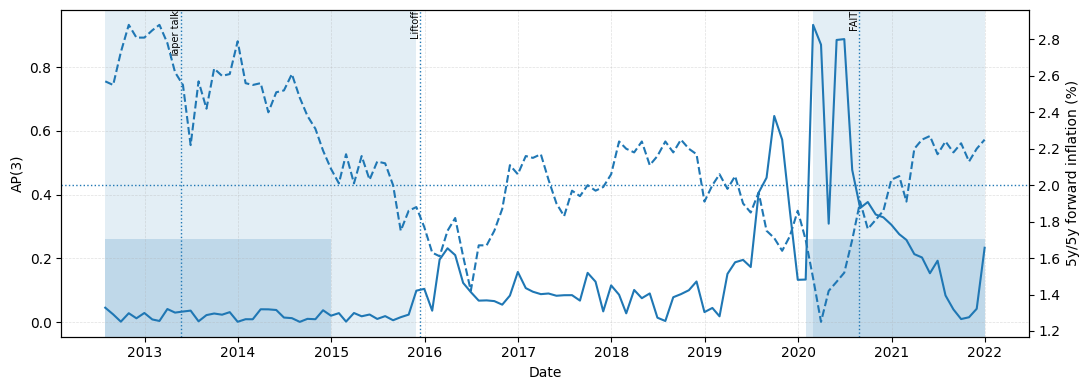


[Appendix] Fed: AP(3) by |5y5y-2| quantile buckets (EOM 5y5y)
  q25(|dev|)=0.1225   q75(|dev|)=0.4650
                 anch_bucket_q  n  mean_AP3  sd_AP3  mean_abs_dev  mean_5y5y
Bottom quartile (closer to 2%) 29    0.1218  0.1085        0.0552     2.0014
                    Middle 50% 56    0.1359  0.1472        0.2338     2.0177
Top quartile (farther from 2%) 29    0.1530  0.3068        0.6366     2.4000

[Appendix] Fed: AP(3) by 5y5y anchored band around 2% (±0.50pp; EOM 5y5y)
   anch_band  n  mean_AP3  sd_AP3  mean_5y5y  mean_abs_dev
  Below 1.50  5    0.6180  0.3885     1.4100        0.5900
1.50 to 2.50 87    0.1383  0.1566     2.0118        0.1799
  Above 2.50 22    0.0208  0.0142     2.6614        0.6614

[Appendix] Fed regression: AP(3) on |5y5y-2| + year FE + month FE (HAC)
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2837      0.150     -1.8

In [6]:
# ============================================================
# Appendix Case Study (Fed): AP(3) vs 5y/5y Forward Inflation (T5YIFR)
# Journal-ready, PRINT-ONLY (no files created)
#
# What this cell does (3 steps):
#   (A) Plot: AP(3) vs 5y/5y (EOM) with ELB/QE shading + key Fed events
#   (B) Mini-tables: AP(3) by |5y5y-2| quantiles + anchored band around 2%
#   (C) Fed-only regression: AP(3) on |5y5y-2| + year FE + month FE (HAC)
#
# Dependencies (must be defined in your FIRST cell):
#   CFG, resolve_root, to_monthly_panel, estimate_reaction_function_realtime,
#   merge_no_overlap, shade_regime
#
# Data:
#   /mnt/data/supportive.xlsx (sheet "Daily", cols: observation_date, T5YIFR)
# ============================================================

import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


# -----------------------------
# USER SETTINGS (paper-consistent)
# -----------------------------
SUPPORT_XLS = "/mnt/data/supportive.xlsx" if os.path.exists("/mnt/data/supportive.xlsx") else "/content/supportive.xlsx"
SUPPORT_SHEET = "Daily"
DATE_COL = "observation_date"
VALUE_COL = "T5YIFR"

BANK = "Fed"
PI_STAR = 2.0              # target inflation (2%)
ANCHOR_BAND = 0.50         # anchored band around target: [2-0.5, 2+0.5]
W_BASE = 84                # baseline rolling RF window (Appendix A1/Table 6)
ELB_MODE = "data_driven"   # must match your baseline pipeline
HAC_LAGS = int(CFG.HAC_LAGS_BASE) if "CFG" in globals() else 6

FED_EVENTS = {
    "Taper talk": pd.Timestamp("2013-05-22"),
    "Liftoff":    pd.Timestamp("2015-12-16"),
    "FAIT":       pd.Timestamp("2020-08-27"),
}
# -----------------------------
# END USER SETTINGS
# -----------------------------


# -----------------------------
# Safety: ensure required functions exist
# -----------------------------
_required = ["CFG", "resolve_root", "to_monthly_panel", "estimate_reaction_function_realtime", "merge_no_overlap"]
_missing = [x for x in _required if x not in globals()]
if _missing:
    raise RuntimeError(f"Missing required objects from first cell: {_missing}. Run the main (journal-ready) code cell first.")

if "shade_regime" not in globals():
    # Fallback shading function (only if your first cell didn't define it)
    def shade_regime(ax, dates, flag, ymin=0.0, ymax=1.0, alpha=0.15):
        in_seg = False
        start = None
        dates = pd.Series(dates).reset_index(drop=True)
        flag = pd.Series(flag).reset_index(drop=True).fillna(0).astype(int)
        for t, (dt, f) in enumerate(zip(dates, flag)):
            if f and not in_seg:
                in_seg = True
                start = dt
            elif (not f) and in_seg:
                ax.axvspan(start, dates.iloc[t - 1], ymin=ymin, ymax=ymax, alpha=alpha)
                in_seg = False
        if in_seg:
            ax.axvspan(start, dates.iloc[-1], ymin=ymin, ymax=ymax, alpha=alpha)


# -----------------------------
# 0) Load 5y/5y forward inflation and convert to END-OF-MONTH (EOM)
# -----------------------------
fwd = pd.read_excel(SUPPORT_XLS, sheet_name=SUPPORT_SHEET)

if DATE_COL not in fwd.columns or VALUE_COL not in fwd.columns:
    raise ValueError(f"Expected columns '{DATE_COL}' and '{VALUE_COL}' in {SUPPORT_XLS} / sheet '{SUPPORT_SHEET}'.")

fwd = fwd.rename(columns={DATE_COL: "date"})
fwd["date"] = pd.to_datetime(fwd["date"], errors="coerce")
fwd[VALUE_COL] = pd.to_numeric(fwd[VALUE_COL], errors="coerce")
fwd = fwd.dropna(subset=["date", VALUE_COL]).sort_values("date")

# EOM: take last available daily observation in each month and align index at month-end
t5y5y_m = (
    fwd.set_index("date")[VALUE_COL]
       .resample("ME").last()
       .rename("t5y5y")
)

# -----------------------------
# 1) Build ONLY what we need for Fed AP(3) with baseline W=84
# -----------------------------
root = resolve_root(CFG)
xls_path = root / CFG.XLS_NAME
if not xls_path.exists():
    raise FileNotFoundError(f"Cannot find {CFG.XLS_NAME} under {root}. Put it in /mnt/data or /content.")

# Monthly panel (same construction as main pipeline)
mon_cs = to_monthly_panel(xls_path, cfg=CFG, rho=CFG.RHO_DEFAULT, elb_mode=ELB_MODE)

# Rolling RF surprises (baseline window)
rf = estimate_reaction_function_realtime(mon_cs, window=W_BASE)

# Merge surprises into panel
mon_cs = merge_no_overlap(mon_cs, rf, on=["bank", "date"], suffix="_rf", validate="one_to_one")
if "di_surpr_rt_rf" in mon_cs.columns:
    mon_cs["di_surpr_rt"] = mon_cs["di_surpr_rt_rf"]

# AP(3) = |sum_{t+1..t+3} di_surpr_rt|
mon_cs = mon_cs.sort_values(["bank", "date"]).copy()
mon_cs["AP3"] = mon_cs.groupby("bank")["di_surpr_rt"].transform(
    lambda s: s.shift(-1).rolling(3, min_periods=3).sum().abs()
)

# Fed-only and merge EOM 5y5y
fed = mon_cs[mon_cs["bank"] == BANK].copy()
fed = fed.dropna(subset=["date", "AP3"]).sort_values("date")
fed = fed.merge(t5y5y_m.reset_index(), on="date", how="left", validate="one_to_one")

fed["abs_anch_dev"] = (fed["t5y5y"] - PI_STAR).abs()

# Merge check / sample span diagnostics
joint = fed.dropna(subset=["AP3", "t5y5y"]).copy()

print(f"\n[Appendix] Fed merge check (baseline W={W_BASE}; T5YIFR=EOM; π*={PI_STAR:.1f})")
print("  Fed AP(3) obs:", int(fed["AP3"].notna().sum()))
print("  Fed 5y5y obs:", int(fed["t5y5y"].notna().sum()))
print("  Joint obs   :", int(joint.shape[0]))
print("  Sample span :", joint["date"].min().date(), "→", joint["date"].max().date())
print("  Note        : AP(3) starts later because RF needs enough history + AP(3) uses t+1..t+3 leads.")

# -----------------------------
# 2A) FIGURE: AP(3) vs 5y/5y (EOM) with ELB/QE shading
# -----------------------------
g = joint.copy()

fig, ax1 = plt.subplots(figsize=(11, 4))
ax1.plot(g["date"], g["AP3"], label="AP(3)")
ax1.set_ylabel("AP(3)")
ax1.set_xlabel("Date")

# Shade ELB and QE_FG
shade_regime(ax1, g["date"], g["ELB"].fillna(0).astype(int), ymin=0.0, ymax=1.0, alpha=0.12)
shade_regime(ax1, g["date"], g["QE_FG"].fillna(0).astype(int), ymin=0.0, ymax=0.30, alpha=0.18)

# Second axis for 5y/5y
ax2 = ax1.twinx()
ax2.plot(g["date"], g["t5y5y"], linestyle="--", label="5y/5y forward inflation (EOM)")
ax2.axhline(PI_STAR, linestyle=":", linewidth=1.0)
ax2.set_ylabel("5y/5y forward inflation (%)")

# Events
y_top = ax1.get_ylim()[1]
for lab, dt_ev in FED_EVENTS.items():
    if g["date"].min() <= dt_ev <= g["date"].max():
        ax1.axvline(dt_ev, linestyle=":", linewidth=1.0)
        ax1.text(dt_ev, y_top, lab, rotation=90, va="top", ha="right", fontsize=7)

ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
fig.tight_layout()
plt.show()

# -----------------------------
# 2B) MINI-TABLES: AP(3) by anchoring regimes
# -----------------------------
tmp = joint.copy()

# (i) Quantile buckets on |5y5y-2|
q25 = tmp["abs_anch_dev"].quantile(0.25)
q75 = tmp["abs_anch_dev"].quantile(0.75)

tmp["anch_bucket_q"] = np.where(
    tmp["abs_anch_dev"] <= q25, "Bottom quartile (closer to 2%)",
    np.where(tmp["abs_anch_dev"] >= q75, "Top quartile (farther from 2%)", "Middle 50%")
)

tab_q = (
    tmp.groupby("anch_bucket_q")
       .agg(
           n=("AP3", "count"),
           mean_AP3=("AP3", "mean"),
           sd_AP3=("AP3", "std"),
           mean_abs_dev=("abs_anch_dev", "mean"),
           mean_5y5y=("t5y5y", "mean"),
       )
       .reset_index()
)

print("\n[Appendix] Fed: AP(3) by |5y5y-2| quantile buckets (EOM 5y5y)")
print(f"  q25(|dev|)={q25:.4f}   q75(|dev|)={q75:.4f}")
print(tab_q.to_string(index=False, float_format=lambda x: f"{x:,.4f}"))

# (ii) Anchored band around 2%: [2-ANCHOR_BAND, 2+ANCHOR_BAND]
low, high = PI_STAR - ANCHOR_BAND, PI_STAR + ANCHOR_BAND
tmp["anch_band"] = pd.cut(
    tmp["t5y5y"],
    bins=[-np.inf, low, high, np.inf],
    labels=[f"Below {low:.2f}", f"{low:.2f} to {high:.2f}", f"Above {high:.2f}"],
    right=True,
)

tab_band = (
    tmp.groupby("anch_band", observed=True)
       .agg(
           n=("AP3", "count"),
           mean_AP3=("AP3", "mean"),
           sd_AP3=("AP3", "std"),
           mean_5y5y=("t5y5y", "mean"),
           mean_abs_dev=("abs_anch_dev", "mean"),
       )
       .reset_index()
)

print(f"\n[Appendix] Fed: AP(3) by 5y5y anchored band around 2% (±{ANCHOR_BAND:.2f}pp; EOM 5y5y)")
print(tab_band.to_string(index=False, float_format=lambda x: f"{x:,.4f}"))

# -----------------------------
# 2C) REGRESSION: AP(3) on |5y5y-2| + year FE + month FE (Fed-only), HAC
# -----------------------------
reg = tmp.copy()
reg["year"] = reg["date"].dt.year
reg["month"] = reg["date"].dt.month

X = pd.DataFrame({"const": 1.0, "abs_anch_dev": reg["abs_anch_dev"].astype(float)}, index=reg.index)
X = pd.concat(
    [
        X,
        pd.get_dummies(reg["year"], prefix="y", drop_first=True).astype(float),
        pd.get_dummies(reg["month"], prefix="m", drop_first=True).astype(float),
    ],
    axis=1,
)

y = reg["AP3"].astype(float)
res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": HAC_LAGS})

print("\n[Appendix] Fed regression: AP(3) on |5y5y-2| + year FE + month FE (HAC)")
print(res.summary().tables[1])

b = float(res.params.get("abs_anch_dev", np.nan))
se = float(res.bse.get("abs_anch_dev", np.nan))
p = float(res.pvalues.get("abs_anch_dev", np.nan))
print(f"\nKey coef: beta(|5y5y-2|) = {b:+.4f}, se = {se:.4f}, p = {p:.3f}")